<a href="https://colab.research.google.com/github/fajemila/zindi-Wheat-g-Challenge/blob/master/CGIAR_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import requests
import requests, zipfile

#the url and auth_value from the website 
url = "https://api.zindi.africa/v1/competitions/cgiar-wheat-growth-stage-challenge/files/Images.zip"
myobj = {'auth_token': 'wLQWzzvtzxnYfG5kVe6CLxfg'} #use your own

x = requests.post(url, data = myobj,stream=True)
target_path = 'image.zip'


In [2]:
handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

!unzip -qq /content/image.zip

In [3]:
import warnings
warnings.filterwarnings('ignore')
import torch,torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, GroupKFold,train_test_split
import pandas as pd
import torch
import numpy as np
import gc
import os
from PIL import Image
from PIL import ImageFile
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations
from sklearn import metrics
from sklearn.model_selection import train_test_split
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

In [4]:
from keras.utils import to_categorical

In [5]:
!pip install wtfml

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
seed = 2020 # for reproductibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
from wtfml.utils import EarlyStopping
from sklearn import model_selection

In [9]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/cgiar/Train.csv')
submission = pd.read_csv('/content/drive/My Drive/cgiar/SampleSubmission.csv')

In [10]:
data.head()

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


In [11]:
mapping = {1:0,2:1,3:2,4:3,5:4,6:5,7:6}
data['growth_stage'] = data['growth_stage'].map(mapping)

In [12]:
submission.head()

,UID,growth_stage
0,F3LbWkZq,0
1,6P4wLVzI,0
2,Tn6HIrdS,0
3,EYM5R1TK,0
4,fkcevlA0,0


In [13]:
submission.shape

(3558, 2)

In [14]:
data.growth_stage.value_counts()

0    3057
6    2335
3    1712
1    1389
4    1092
2     689
5     421
Name: growth_stage, dtype: int64

In [15]:
data.label_quality.value_counts()

1    7839
2    2856
Name: label_quality, dtype: int64

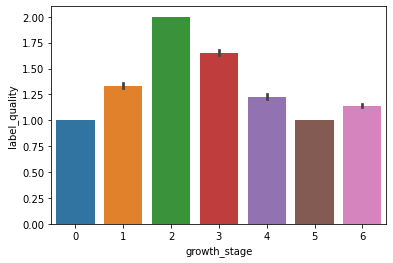

In [16]:
import seaborn as sns
sns.barplot(x='growth_stage',y='label_quality',data=data)

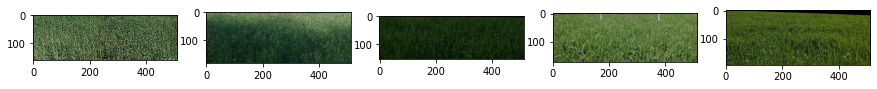

In [17]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize=(15,10))

for i,idx in enumerate(data[data['growth_stage'] == 4]['UID'][-5:]):
    path = '/content/Images/' + idx + '.jpeg'
    ax[i].imshow(img.imread(path))

In [18]:
from PIL import Image
import cv2
for ind in data[data['growth_stage'] == 5]['UID'][-5:]:
    pathe = '/content/Images/' + ind + '.jpeg'
    
    imgr = cv2.imread(pathe)
    print(imgr.size)
    imgr = cv2.resize(imgr,dsize=(256,256))

    print(imgr.size)
    print(imgr.shape)#oe)
    print(type(imgr))

282624
196608
(256, 256, 3)
<class 'numpy.ndarray'>
273408
196608
(256, 256, 3)
<class 'numpy.ndarray'>
325632
196608
(256, 256, 3)
<class 'numpy.ndarray'>
244224
196608
(256, 256, 3)
<class 'numpy.ndarray'>
259584
196608
(256, 256, 3)
<class 'numpy.ndarray'>


In [20]:
class CGIARGWHEAT(Dataset):
    def __init__(self, data, traindata = None, transform = None):
        super().__init__()
        self.data = data
        self.path = path
        self.transform = transform
        self.traindata = traindata
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img_path = '/content/Images/' + self.data.iloc[index]['UID'] + '.jpeg'
        #image = img
        image = cv2.imread(img_path)
        image = torch.Tensor(cv2.resize(image,dsize= (299,299))).permute(2,0,1)
        # image = image[0:224, 0:224]
        if self.transform:#s:
            image = self.transform(image)#s(image)
            
        if self.traindata:
            label = self.data.iloc[index]['growth_stage']
            return image,label
        else:
            return image

In [41]:
class CGIARGWHEAT:
    def __init__(self,image_paths,targets,resize=None,augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item])
        image = image.convert("RGB")
        targets = self.targets[item]
        if self.resize is not None:
            image = image.resize(
                        (self.resize[1], self.resize[0]),
                        resample=Image.BILINEAR
            )
        image = np.array(image)
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(to_categorical(targets,7), dtype=torch.long),
        }

In [20]:
# engine.py
import torch
import torch.nn as nn
from tqdm import tqdm
def train_fn(data_loader, model, optimizer, device):
    avg_loss = 0
    model.train()
    for data in data_loader:
        inputs = data["image"]
        targets = data["targets"]
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.BCELoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()* data["image"].size(0)

    # avg_loss_nump = avg_loss.cpu().detach().numpy()
    print('[Training] Loss: {:.5f}'.format( avg_loss/len(data_loader.sampler)))


In [57]:
def evaluate(data_loader, model, device):
    model.eval()
    final_targets = []
    final_outputs = []
    avg_loss = 0
    avg_acc = 0
    with torch.no_grad():
        for data in data_loader:
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            output = model(inputs)
            loss = nn.BCELoss()(output, targets)
            targets = targets.argmax(1)
            output = output.argmax(1)  #y.argmax(1) == pred.argmax(1)
          #avg_acc += (targets.argmax(1) == output.argmax(1)).float().mean()
            final_targets.extend(targets)
            final_outputs.extend(output)
            avg_loss+=loss.item()* data["image"].size(0)
       # avg_acc_nump = avg_acc.cpu().detach().numpy()
    print('[Evaluation] Loss: {:.5f}'.format(avg_loss/len(data_loader.sampler)))
    return final_outputs, final_targets

In [22]:
# create folds
df = pd.read_csv('/content/drive/My Drive/cgiar/Train.csv')
df["kfold"] = -1    
df = df.sample(frac=1).reset_index(drop=True)
y = df.growth_stage.values
kf = model_selection.StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

df.to_csv("train_folds.csv", index=False)

In [23]:
from torch.nn import functional as F

In [32]:
class Model(nn.Module):
    def __init__(self, arch):
        super(Model, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=7, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=7, bias=True)
        if 'DenseNet' in str(arch.__class__):
            self.arch.classifier = nn.Linear(in_features=1024, out_features=7, bias=True)
        self.Linear = nn.Linear(1024,2)
    def forward(self, inputs):
        x = inputs
        x = self.arch(x)
        # x = self.Linear(x)
        x = F.sigmoid(x)
        return x

In [25]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [58]:
from math import sqrt

In [59]:
def train(fold):
    training_data_path = '/content/Images' 
    df =  pd.read_csv("/content/train_folds.csv")
    device = "cuda"
    epochs = 50
    train_bs = 16
    valid_bs = 16
    mapping = {1:0,2:1,3:2,4:3,5:4,6:5,7:6}
    df['growth_stage'] = df['growth_stage'].map(mapping)
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    arch = torchvision.models.densenet121(pretrained=True)
    model = Model(arch=arch)
    model.to(device)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    train_aug = albumentations.Compose([albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
            albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
            albumentations.Flip(p=0.5)])

    valid_aug = albumentations.Compose([albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)])

    train_images = df_train.UID.values.tolist()
    train_images = [os.path.join(training_data_path, i + '.jpeg') for i in train_images]
    train_targets = df_train.growth_stage.values

    valid_images = df_valid.UID.values.tolist()
    valid_images = [os.path.join(training_data_path, i+'.jpeg') for i in valid_images]
    valid_targets = df_valid.growth_stage.values

    train_dataset = CGIARGWHEAT(image_paths=train_images,targets=train_targets,resize=(256, 256),augmentations=train_aug)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_bs, shuffle=True, num_workers=4)

    valid_dataset = CGIARGWHEAT(image_paths=valid_images,targets=valid_targets, resize=(256, 256),augmentations=valid_aug)


    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_bs, shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,threshold=0.001,mode="min")

    es = EarlyStopping(patience=5, mode="min")

    for epoch in range(epochs):
        train_loss = train_fn(train_loader, model, optimizer, device=device)
        predictions, target = evaluate(
            valid_loader, model, device=device
        )
        rmse = sqrt(metrics.mean_squared_error(target, predictions))
        print(f"Epoch = {epoch}, RMSE = {rmse}")
        scheduler.step(rmse)

        es(rmse, model, model_path=f"model_fold_{fold}.bin")
        if es.early_stop:
            print("Early stopping")
            break#l

In [ ]:
train(0)
train(1)
train(2)
train(3)
train(4)

[Training] Loss: 0.45596
[Evaluation] Loss: 0.33413
Epoch = 0, RMSE = 2.579362116765745
Validation score improved (inf --> 2.579362116765745). Saving model!


In [ ]:
# our dataloader is ready.
# let's make model

# building blocks for mobilenet.
# name Conv and Conv_dw are following the terms used in mobilenet paper (https://arxiv.org/pdf/1704.04861.pdf)

class Conv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            )
        
    def forward(self, input):
        return self.layers(input)
    
class Conv_dw_Conv(nn.Module):
    # Conv dw layer followed by Conv layer.
    # implemented this way since every conv dw layer is followed by conv layer with kernel size 1, stride 1 with some out_channel
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Conv2d(in_channel, in_channel, kernel_size, stride, padding, bias=False, groups=in_channel),
                nn.BatchNorm2d(in_channel),
                nn.ReLU(inplace=True),
                Conv(in_channel, out_channel, kernel_size=1, stride=1, padding=0)
            )
        
    def forward(self, input):
        return self.layers(input)
    
    
class MobileNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.model = nn.Sequential(
                Conv(3, 32, stride=2),
                Conv_dw_Conv(32, 64, kernel_size=3, stride=1),
                Conv_dw_Conv(64, 128, kernel_size=3, stride=2),
                Conv_dw_Conv(128, 128, kernel_size=3, stride=1),
                Conv_dw_Conv(128, 256, kernel_size=3, stride=2),
                Conv_dw_Conv(256, 256, kernel_size=3, stride=1),
                Conv_dw_Conv(256, 512, kernel_size=3, stride=2),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 512, kernel_size=3, stride=1),
                Conv_dw_Conv(512, 1024, kernel_size=3, stride=2),
                Conv_dw_Conv(1024, 1024, kernel_size=3, stride=1)
        )
        
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, input):
        x = self.model(input)
        x = self.avg_pool(x)
        x = x.view(-1, 1024)
        out = self.fc(x)
        return out

In [ ]:

train_losses = []
valid_losses = []
for epoch in range(1, num_epochs + 1):
    y_true = []
    y_pred = []
    train_loss = 0.0
    valid_loss = 0.0
    # scheduler.step()
    model_ft.train()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model_ft(data)
        # target = target.unsqueeze(1).type_as(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
    model_ft.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            # target = target.unsqueeze(1).type_as(output)
            output = model_ft(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # print-training/validation-statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 1.043769 	Validation Loss: 1.261589
